# How Does a Movie’s IMDb Rating Relate to Its Box Office Success?
Introduction

The film industry is a complex ecosystem where various factors contribute to a movie’s success. Among these factors, audience reception and financial performance are two critical metrics. This analysis aims to explore the relationship between a movie’s IMDb rating—a reflection of audience and critic reception—and its box office revenue. Understanding this relationship can provide valuable insights for filmmakers, producers, investors as well as researchers such as us.

Research Question: How does a movie’s IMDb rating relate to its box office success? Is the rating coherent with the movie’s financial success?

## 1. Data Loading and Preprocessing

Importing Libraries

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from scipy import stats
%matplotlib inline

Loading the Dataset

In [134]:
# load the dataset
df = pd.read_csv("../data/movies_combined_inflated.csv")

df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,...,combined_revenue,release_month,release_day,primaryTitle,startYear,averageRating,numVotes,tconst,director,inflated_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...",2001.0,...,14010832.0,8.0,24.0,Ghosts of Mars,2001.0,4.9,58868.0,tt0228333,John Carpenter,1.899115e+07
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...",1938.0,...,4000000.0,8.0,16.0,Alexander's Ragtime Band,1938.0,6.8,2357.0,tt0029852,Henry King,6.812740e+07
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"[('/m/02h40lc', 'English Language')]","[('/m/07ssc', 'United Kingdom')]","[('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...",1989.0,...,10161099.0,11.0,8.0,Henry V,1989.0,7.5,32088.0,tt0097499,Kenneth Branagh,1.967252e+07
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/0hj3myq', ""Children's/Family""), ('/m/04t...",1964.0,...,102272727.0,8.0,27.0,Mary Poppins,1964.0,7.8,189183.0,tt0058331,Robert Stevenson,7.913870e+08
4,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...",1999.0,...,21521.0,10.0,1.0,NaN,NaN,0.0,0.0,NaN,Unknown,3.100822e+04


### Selecting Relevant Columns
For this analysis, we’ll focus on the following columns:
*	averageRating: The IMDb rating of the movie.
*	inflated_revenue: The box office revenue adjusted for inflation.
*	numVotes: The number of votes the movie received on IMDb.
*   movie_genres: The genres of the movie.

In [135]:
# Select relevant columns
data = df[
    ["movie_name", "averageRating", "inflated_revenue", "numVotes", "movie_genres"]
]

#### Handling Missing Values
We’ll check and remove the rows that contains no votes or revenue information.

In [136]:
# Drop rows with missing values or zero numVotes
data.dropna(
    subset=["averageRating", "inflated_revenue", "numVotes"],
    inplace=True,
)
data = data[data.numVotes > 0]

/var/folders/3w/x7g6gh3s1y1gry1przjtc12c0000gn/T/ipykernel_29315/2063343102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(


#### Handling Duplicates

In [137]:
# Check for duplicates
data.duplicated().sum()

# remove duplicates if any
data.drop_duplicates(inplace=True)

In [138]:
# Split genres into a list of genres names
data["genres_list"] = data["movie_genres"].apply(
    lambda x: [genre[1] for genre in eval(x)]
)

## Exploratory Data Analysis

#### Summary Statistics

In [139]:
data.describe()

,averageRating,inflated_revenue,numVotes
count,7935.000000,7.935000e+03,7.935000e+03
mean,6.429931,8.483343e+07,7.854191e+04
std,0.969471,2.060112e+08,1.774744e+05
min,1.600000,1.355462e+00,7.400000e+01
25%,5.900000,6.352539e+06,5.690500e+03
50%,6.500000,2.494240e+07,2.008900e+04
75%,7.100000,8.024377e+07,7.243900e+04
max,9.300000,6.905588e+09,2.959489e+06


#### Number of Movies per Genre

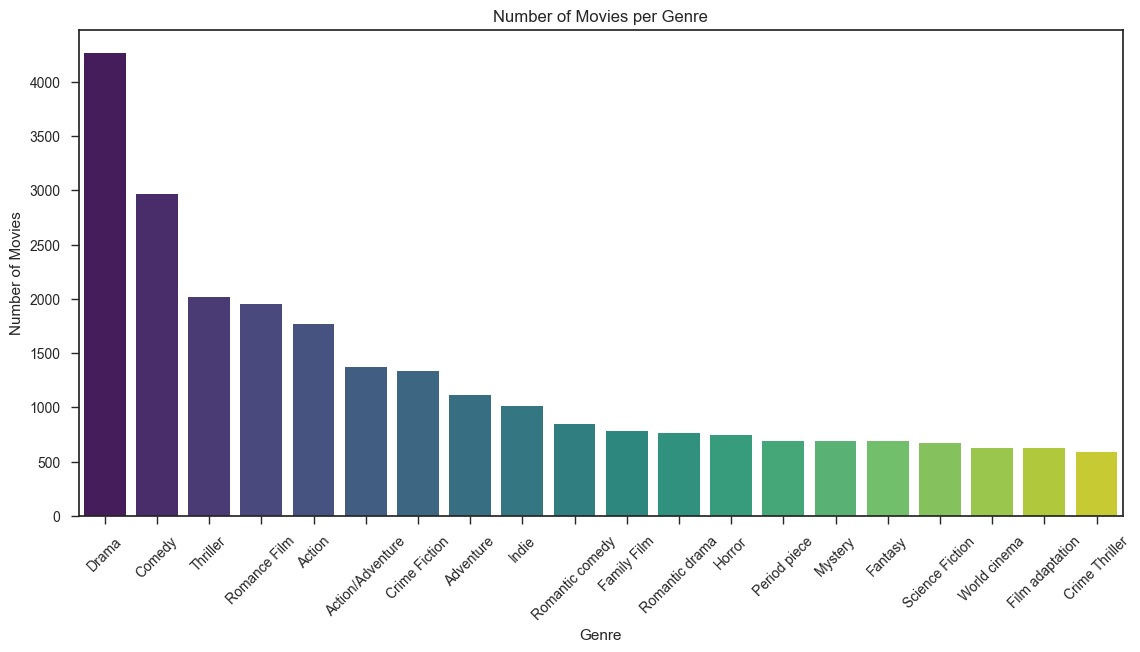

In [140]:
# Explode the genres_list to count each genre separately
genre_counts = data.explode("genres_list")["genres_list"].value_counts()

# get the most common 20 genres
genre_counts_top20 = genre_counts.head(20)


plt.figure(figsize=(12, 6))
sns.barplot(
    x=genre_counts_top20.index,
    y=genre_counts_top20.values,
    palette="viridis",
    hue=genre_counts_top20.index,
)
plt.title("Number of Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()

#### Distribution of IMDb Ratings

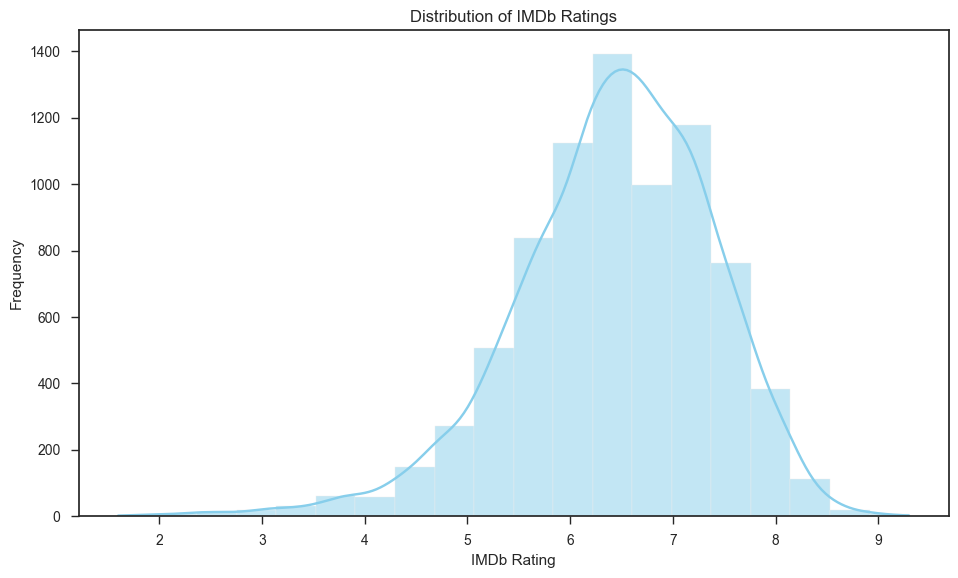

In [141]:
plt.figure(figsize=(10, 6))
sns.histplot(data["averageRating"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.show()

#### Distribution of Box Office Revenue
Due to the wide range of revenues, we’ll use a logarithmic scale.

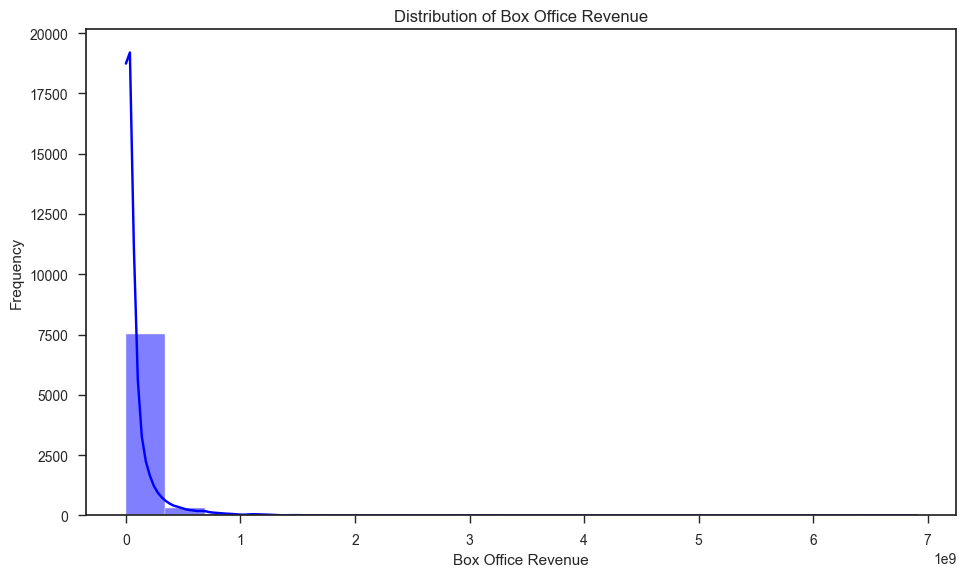

In [142]:
plt.figure(figsize=(10, 6))
sns.histplot(data["inflated_revenue"], bins=20, kde=True, color="blue")
plt.title("Distribution of Box Office Revenue")
plt.xlabel("Box Office Revenue")
plt.ylabel("Frequency")
plt.show()

For our analysis, we log-transformed the movie revenue data (using log base 10) for several reasons:

**Distribution Properties**: As we can see from the Distribution of the Box Office Revenue plot above, movie revenues show a right-skewed distribution with a long tail of high-revenue outliers. Log transformation helps normalize this distribution.

**Statistical Considerations**: The transformation helps meet OLS regression assumptions by:
   - Making the relationship more linear
   - Normalizing the distribution of errors


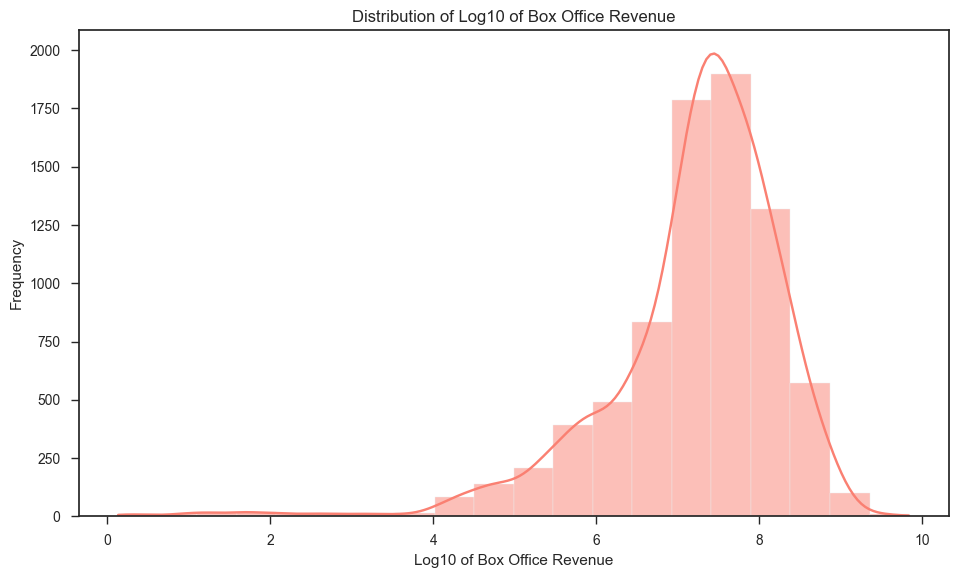

In [143]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log10(data["inflated_revenue"]), bins=20, kde=True, color="salmon")
plt.title("Distribution of Log10 of Box Office Revenue")
plt.xlabel("Log10 of Box Office Revenue")
plt.ylabel("Frequency")
plt.show()


As shown in the plots above, the log transformation provides a more normally distributed dependent variable.

#### Scatter Plot of IMDb Ratings vs. Box Office Revenue

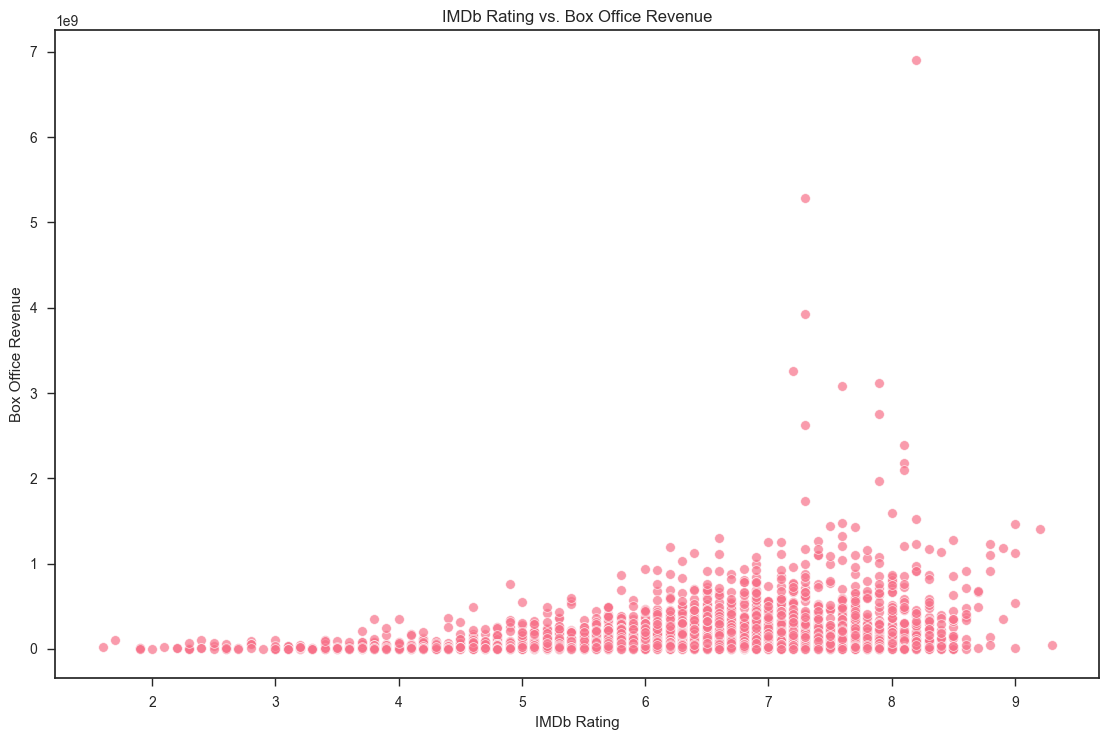

In [144]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="averageRating", y="inflated_revenue", data=data, alpha=0.7)
plt.title("IMDb Rating vs. Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Box Office Revenue")
plt.show()

The scatter plot shows a lot of dispersion. To better visualize the data, we’ll apply a logarithmic transformation to the revenue.

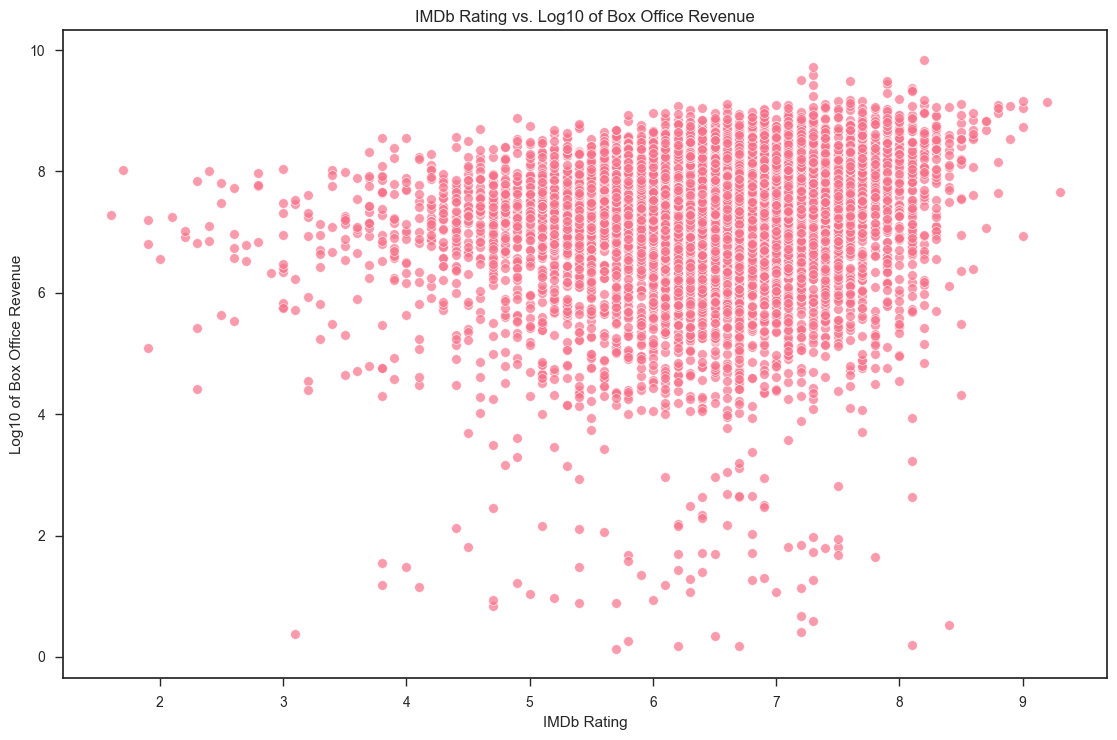

In [145]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="averageRating", y=np.log10(data["inflated_revenue"]), data=data, alpha=0.7
)
plt.title("IMDb Rating vs. Log10 of Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Log10 of Box Office Revenue")
plt.show()

#### Joint Distruibution Plot (IMDb Ratings vs Box Office Revenue)
Said's Note: We may omit this part as more sophisticated visualization is added at the end of the notebook.

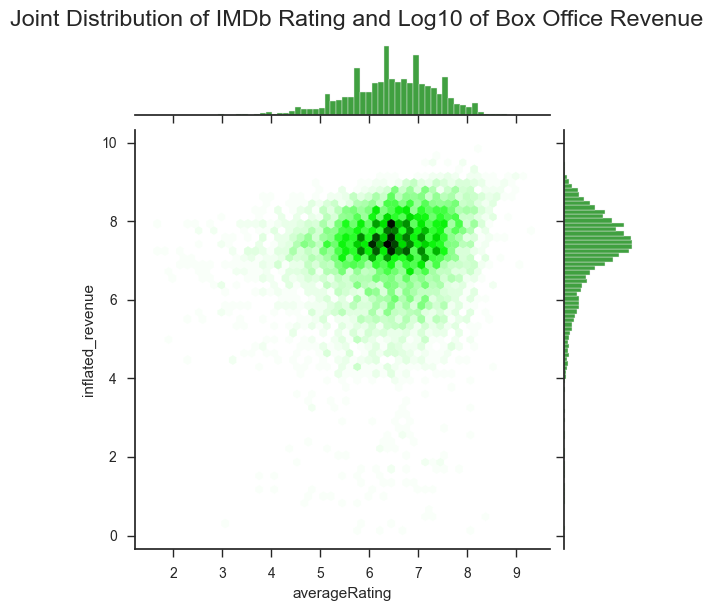

In [146]:
sns.jointplot(
    x="averageRating",
    y=np.log10(data["inflated_revenue"]),
    data=data,
    kind="hex",
    color="green",
)
plt.suptitle(
    "Joint Distribution of IMDb Rating and Log10 of Box Office Revenue", y=1.02
)
plt.show()

## Correlation Analysis

#### Calculating the Correlation Coefficient

In [147]:
# Pearson correlation
corr_pearson = data[["averageRating", "inflated_revenue"]].corr(method="pearson")
print("Pearson Correlation Coefficient:")
print(corr_pearson)

# Spearman correlation
corr_spearman = data[["averageRating", "inflated_revenue"]].corr(method="spearman")
print("\nSpearman Correlation Coefficient:")
print(corr_spearman)

Pearson Correlation Coefficient:
                  averageRating  inflated_revenue
averageRating          1.000000          0.189064
inflated_revenue       0.189064          1.000000

Spearman Correlation Coefficient:
                  averageRating  inflated_revenue
averageRating          1.000000          0.157169
inflated_revenue       0.157169          1.000000


#### Heatmap of Correlation Matrix

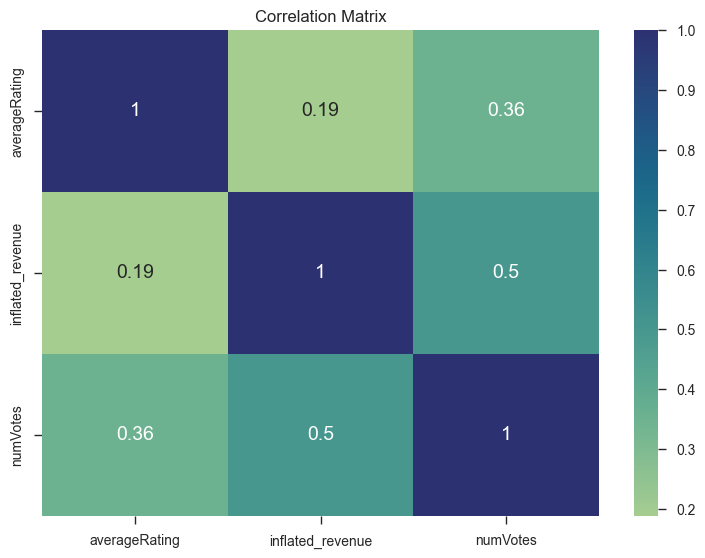

In [148]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    data[["averageRating", "inflated_revenue", "numVotes"]].corr(),
    annot=True,
    cmap="crest",
)
plt.title("Correlation Matrix")
plt.show()

#### Observations
*	The Pearson correlation coefficient between IMDb rating and inflated revenue is 0.188, indicating a weak positive linear relationship.
*	The Spearman correlation coefficient is 0.157, suggests a weak monotonic relationship.

### Genre-wise Correlation
Different genres might exhibit different relationships between ratings and revenue.


#### Function to Calculate Correlations by Genre

In [149]:
def genre_correlation(genre):
    genre_data = data[data["genres_list"].apply(lambda x: genre in x)]
    pearson_corr, _ = pearsonr(
        genre_data["averageRating"], np.log10(genre_data["inflated_revenue"])
    )
    spearman_corr, _ = spearmanr(
        genre_data["averageRating"], np.log10(genre_data["inflated_revenue"])
    )
    return pd.Series(
        {"Genre": genre, "Pearson": pearson_corr, "Spearman": spearman_corr}
    )

#### Calculate Correlations by Genre

In [60]:
# get top 20 genres
genre_counts_filtered = genre_counts.head(20)
genres = genre_counts_filtered.index.tolist()
genre_corrs = pd.DataFrame([genre_correlation(genre) for genre in genres])
genre_corrs.set_index("Genre", inplace=True)
genre_corrs

,Pearson,Spearman
Genre,,
Drama,0.217371,0.230485
Comedy,0.168477,0.186382
Thriller,0.238404,0.258994
Romance Film,0.184061,0.180027
Action,0.279959,0.327892
Action/Adventure,0.254966,0.306993
Crime Fiction,0.204603,0.227275
Adventure,0.255265,0.312972
Indie,0.211690,0.245956


#### Visualizing Genre-wise Correlations

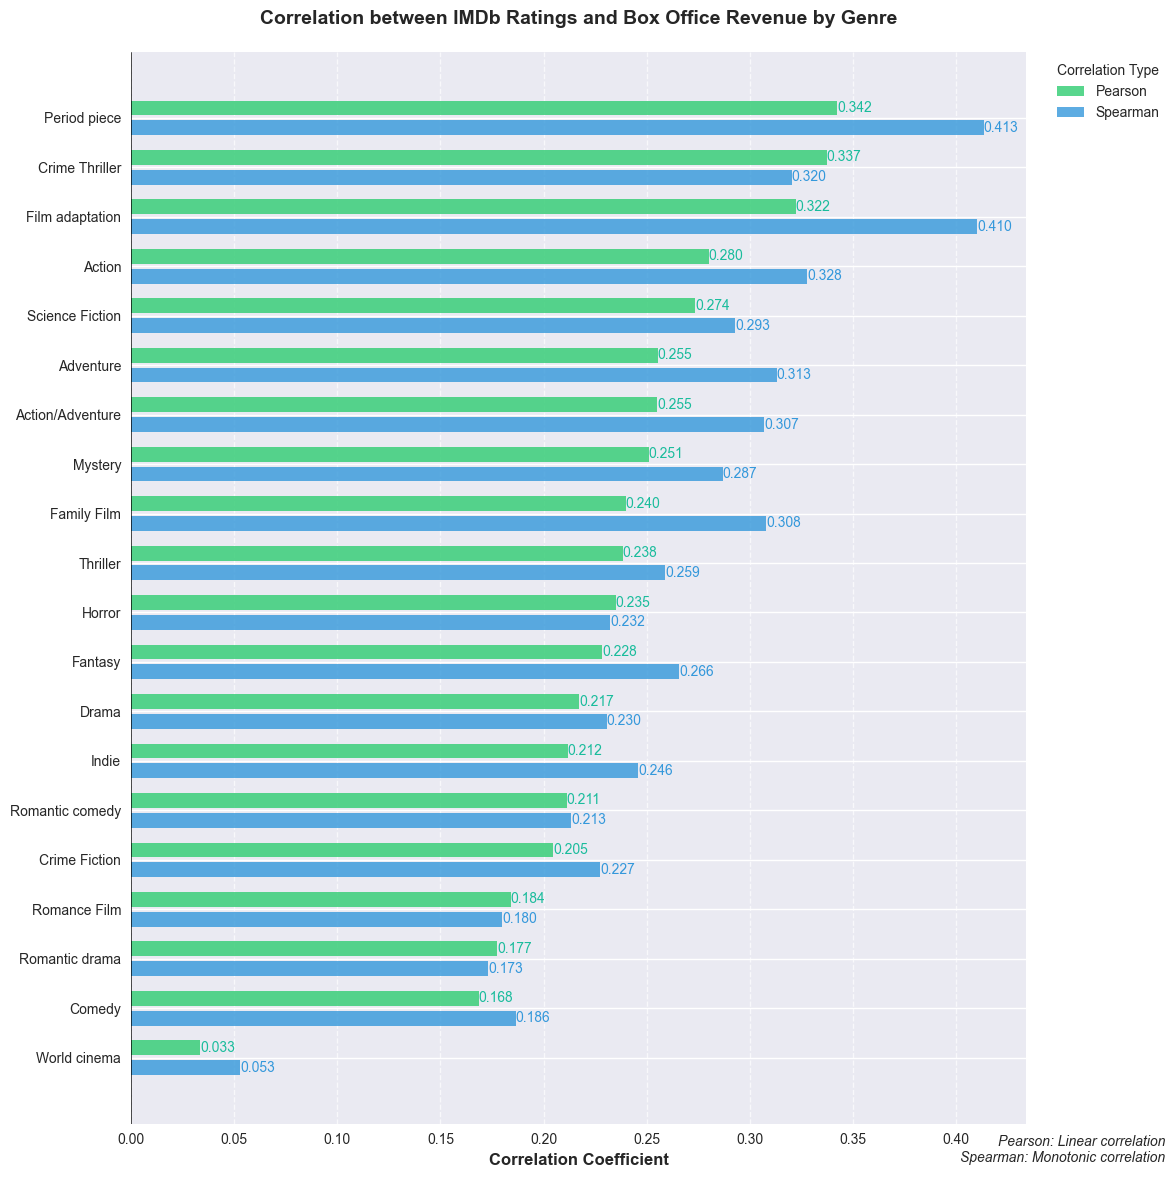

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Create figure
fig, ax = plt.subplots(figsize=(12, 12))

# Sort values for better visualization
genre_corrs_sorted = genre_corrs.sort_values("Pearson", ascending=True)

# Create horizontal bar plot with different colors for Pearson and Spearman
x_pearson = genre_corrs_sorted["Pearson"]
x_spearman = genre_corrs_sorted["Spearman"]
y = range(len(genre_corrs_sorted.index))

# update the x-y matching after reordering


# Plot horizontal bars
ax.barh(
    y=[i + 0.2 for i in y],
    width=x_pearson,
    height=0.3,
    color="#2ecc71",
    alpha=0.8,
    label="Pearson",
)
ax.barh(
    y=[i - 0.2 for i in y],
    width=x_spearman,
    height=0.3,
    color="#3498db",
    alpha=0.8,
    label="Spearman",
)

# Customize the plot
ax.set_yticks(y)
ax.set_yticklabels(genre_corrs_sorted.index, fontsize=10)
ax.set_xlabel("Correlation Coefficient", fontsize=12, fontweight="bold")
ax.set_title(
    "Correlation between IMDb Ratings and Box Office Revenue by Genre",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

# Add gridlines
ax.grid(True, axis="x", linestyle="--", alpha=0.7)

# Add zero line
ax.axvline(x=0, color="black", linestyle="-", linewidth=0.5)

# Add legend
ax.legend(
    title="Correlation Type",
    title_fontsize=10,
    fontsize=10,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
)

# Add value labels on the bars
for i in y:
    # Pearson values
    ax.text(
        x_pearson[i],
        i + 0.2,
        f"{x_pearson[i]:.3f}",
        va="center",
        ha="left" if x_pearson[i] >= 0 else "right",
        fontsize=10,
        color="#1abc9c",  # Modern teal color
    )
    # Spearman values
    ax.text(
        x_spearman[i],
        i - 0.2,
        f"{x_spearman[i]:.3f}",
        va="center",
        ha="left" if x_spearman[i] >= 0 else "right",
        fontsize=10,
        color="#3498db",  # Modern blue color
    )

# Add descriptive text
description = "Pearson: Linear correlation\n" "Spearman: Monotonic correlation"
plt.figtext(
    0.98, 0.02, description, fontsize=10, style="italic", ha="right", va="bottom"
)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Observations
*	Among the genres, some exhibit a stronger correlation between IMDb rating and box office revenue than others.
*	For example, Action movies have a positive correlation of 0.33, while World cinema movies have a near negligible correlation of 0.05.
*   Although the correlation values vary across genres, there is no genre with a negative correlation or a very strong positive correlation between IMDb rating and box office revenue.

## Regression Analysis

### Linear Regression Model

#### Simple Linear Regression

In [37]:
# Prepare the data
X = data[["averageRating"]]
y = np.log10(data["inflated_revenue"])  # Log-transform the revenue

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     172.2
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           6.29e-39
Time:                        01:55:26   Log-Likelihood:                -11974.
No. Observations:                7935   AIC:                         2.395e+04
Df Residuals:                    7933   BIC:                         2.397e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1373      0.082     74.471

#### Multiple Linear Regression: IMDb Rating and Number of Votes vs. Box Office Revenue

In [76]:
# Prepare the data
X_multi = data[["averageRating", "numVotes"]]
y_multi = np.log10(data["inflated_revenue"])

# Log-transform numVotes to normalize
X_multi["log_numVotes"] = np.log10(X_multi["numVotes"])

# Add a constant term
X_multi = sm.add_constant(X_multi[["averageRating", "log_numVotes"]])

# Fit the model
model_multi = sm.OLS(y_multi, X_multi).fit()

# Model summary
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1563.
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        03:42:46   Log-Likelihood:                -10741.
No. Observations:                7935   AIC:                         2.149e+04
Df Residuals:                    7932   BIC:                         2.151e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.1264      0.080     51.676

/var/folders/3w/x7g6gh3s1y1gry1przjtc12c0000gn/T/ipykernel_29315/1932139272.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_multi["log_numVotes"] = np.log10(X_multi["numVotes"])


Interpretation: 
**Model Improvement:** Including log-transformed vote count significantly enhanced the model, with R² rising from 0.021 (rating-only) to 0.283, which shows vote count as a stronger revenue predictor than ratings alone.

**Surprising Rating Effect Shift:** Controlling for votes, the rating coefficient turns slightly negative (-0.0550) compared to its positive effect (0.1663) in the single predictor model. This indicates that higher ratings don’t necessarily increase revenue once popularity (votes) is considered. (Said's Note: This is a surprising result that may effect our other analysis in this section as well)

**Vote Count Impact**: The positive coefficient for log_numVotes (0.7979, p < 0.001) suggests a 10% vote count increase correlates with an 8% revenue boost, that highlights vote count as the primary revenue driver over rating quality.

### 3D Visualization of Multiple Linear Regression Model

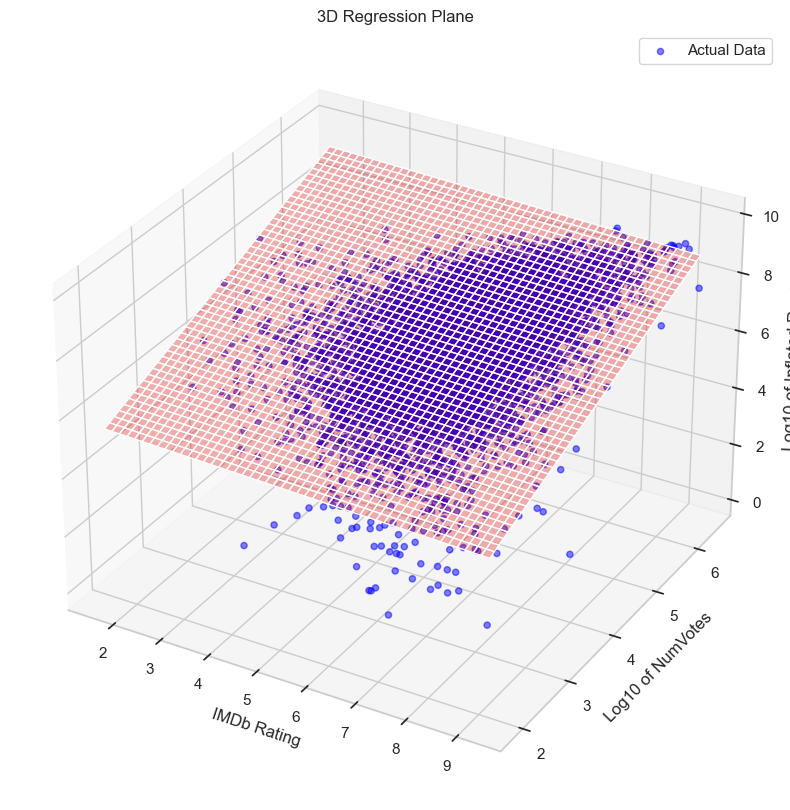

In [ ]:
# Create a meshgrid for plotting
averageRating_range = np.linspace(
    data["averageRating"].min(), data["averageRating"].max(), 50
)
log_numVotes_range = np.linspace(
    np.log10(data["numVotes"]).min(), np.log10(data["numVotes"]).max(), 50
)
averageRating_grid, log_numVotes_grid = np.meshgrid(
    averageRating_range, log_numVotes_range
)
predicted_revenue = model_multi.predict(
    sm.add_constant(
        pd.DataFrame(
            {
                "averageRating": averageRating_grid.ravel(),
                "log_numVotes": log_numVotes_grid.ravel(),
            }
        )
    )
).values.reshape(averageRating_grid.shape)

# Plotting
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    data["averageRating"],
    np.log10(data["numVotes"]),
    np.log10(data["inflated_revenue"]),
    c="blue",
    alpha=0.5,
    label="Actual Data",
)
ax.plot_surface(
    averageRating_grid, log_numVotes_grid, predicted_revenue, color="red", alpha=0.3
)
ax.set_xlabel("IMDb Rating")
ax.set_ylabel("Log10 of NumVotes")
ax.set_zlabel("Log10 of Inflated Revenue")
plt.title("3D Regression Plane")
plt.legend()
plt.show()

#### Regression Plot

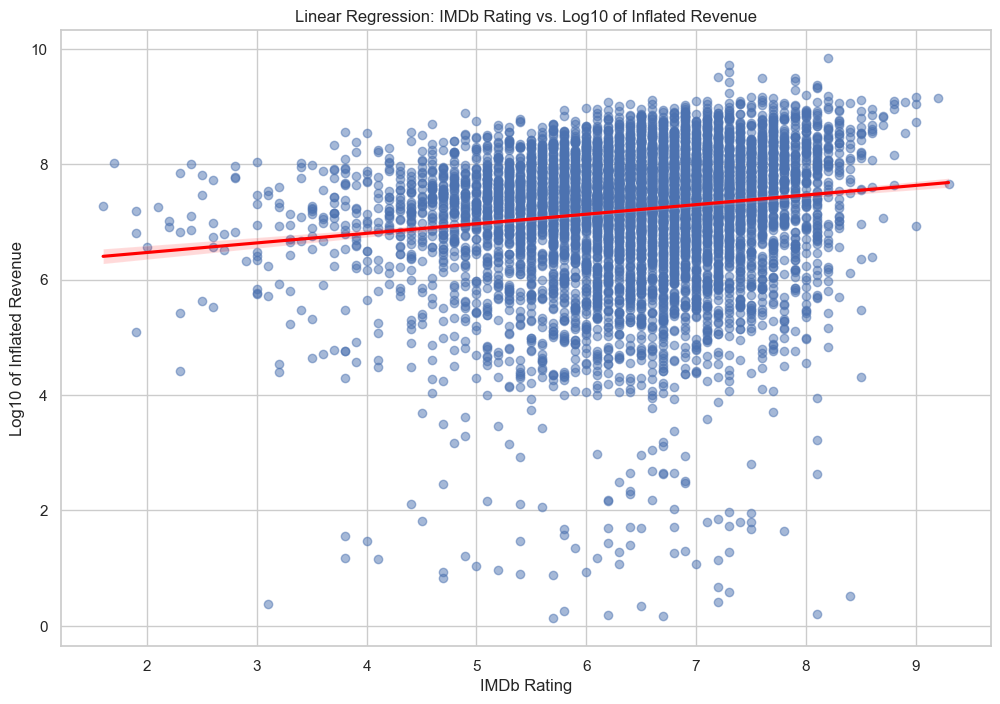

In [ ]:
# TODO Said's Note: Since scatter plot is not a good choice to visualize the regression line for this task (as there are thousands of points), we may omit this plot (as the next plot is more informative with hexbins)
plt.figure(figsize=(12, 8))
sns.regplot(
    x="averageRating",
    y=np.log10(data["inflated_revenue"]),
    data=data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
plt.title("Linear Regression: IMDb Rating vs. Log10 of Inflated Revenue")
plt.xlabel("IMDb Rating")
plt.ylabel("Log10 of Inflated Revenue")
plt.show()

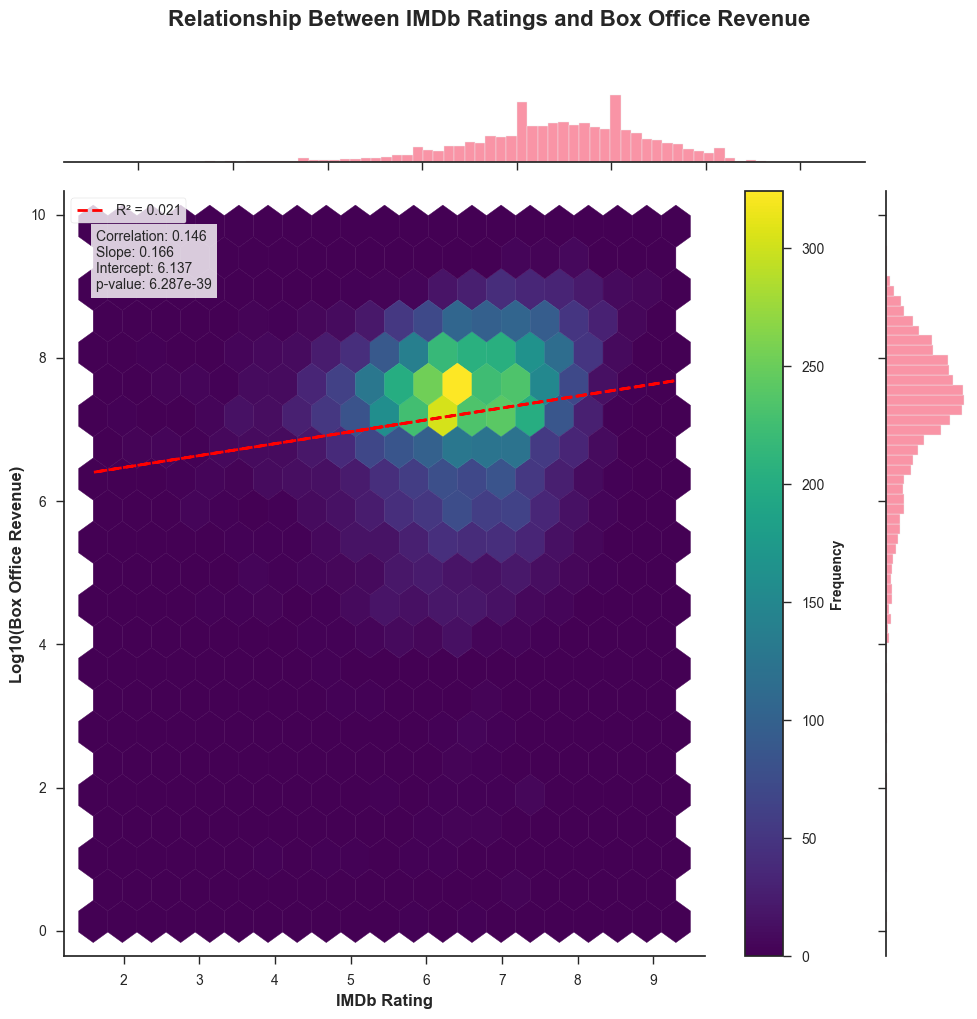

In [ ]:
# Create figure with custom size and style
plt.style.use("seaborn-v0_8-ticks")
sns.set_palette("husl")

# Creation of the joint plot
g = sns.jointplot(
    data=data,
    x="averageRating",
    y=np.log10(data["inflated_revenue"]),
    kind="hex",
    height=10,  # figure size
    ratio=8,  # the ratio of main plot to marginal plots
    marginal_kws=dict(bins=70),  # More bins in marginal plots
    joint_kws=dict(gridsize=20),  # More hexbins for better resolution
    palette="viridis",  # Modern color palette
)

# Add trend line
x = data["averageRating"]
y = np.log10(data["inflated_revenue"])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
g.ax_joint.plot(
    x, line, color="red", linestyle="--", linewidth=2, label=f"R² = {r_value**2:.3f}"
)

# Customize the plot
g.figure.suptitle(
    "Relationship Between IMDb Ratings and Box Office Revenue",
    y=1.02,
    fontsize=16,
    fontweight="bold",
)

# Add descriptive labels
g.ax_joint.set_xlabel("IMDb Rating", fontsize=12, fontweight="bold")
g.ax_joint.set_ylabel("Log10(Box Office Revenue)", fontsize=12, fontweight="bold")

# Add legend with modern color
g.ax_joint.legend(loc="upper left", fontsize=10, frameon=True, facecolor="white")


# Add text box with statistics
stats_text = (
    f"Correlation: {r_value:.3f}\n"
    f"Slope: {slope:.3f}\n"
    f"Intercept: {intercept:.3f}\n"
    f"p-value: {p_value:.3e}"
)
g.ax_joint.text(
    0.05,
    0.95,
    stats_text,
    transform=g.ax_joint.transAxes,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    fontsize=10,
    verticalalignment="top",
)

# Customize hexbin appearance
g.ax_joint.collections[0].set_cmap("viridis")  # Modern colormap


# Add color bar
cbar = g.figure.colorbar(g.ax_joint.collections[0], ax=g.ax_joint, label="Count")
cbar.set_label("Frequency", fontsize=10, fontweight="bold")

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

## Additional Analysis Note: Impact of Vote Count
While our primary analysis focuses on the direct relationship between 
ratings and revenue, we also examined the role of vote counts. As 
expected, we found a strong correlation between number of votes and 
revenue (correlation = 0.50), suggesting that more commercially successful 
movies tend to receive more ratings. However, this relationship 
likely reflects popularity rather than quality, which is why we 
maintained our focus on average ratings for the main analysis.